## Threads vs processes in Python

Writeup of https://www.youtube.com/watch?v=AZnGRKFUU0c

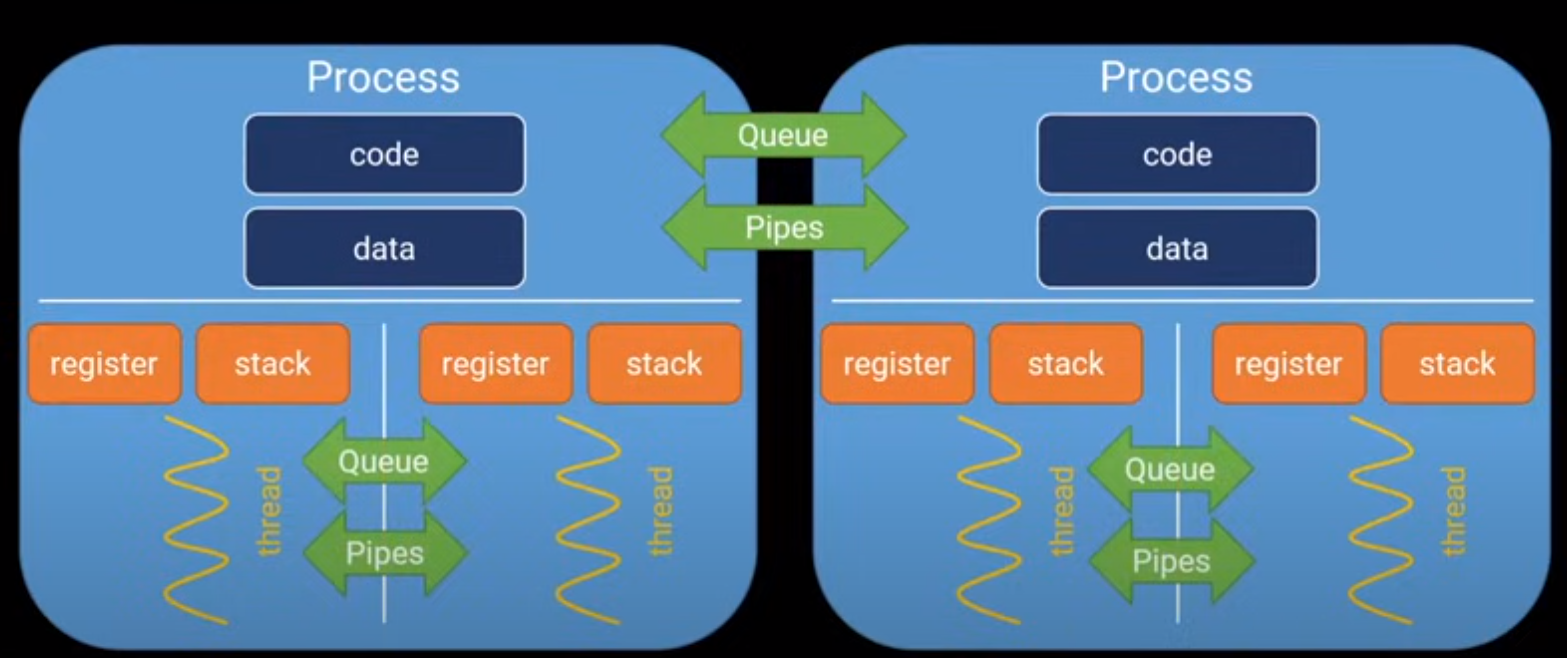

**Threads**:
 - Share code and data
 - Have distinct stacks and registers
 - Concurrent multithreading is not allowed in Python
 - Multithreading in the same Python process has to be sequential

**Processes**:
 - Distinct data allocations, naturally will take `process_mem_needed` $\cdot$ `n_of_processes` of memory
 - Arbitrary number of python processes can be run at the same time

Multithreading can result in a deadlock. Multiprocessing is deadlock safe as processes are not sharing the same data allocation.

**Deadlock** happens when thread 1 is waiting for resource used by thread 2, while thread 2 can't free it as it is waiting for resource used by thread 1.

Python is deadlock safe, as **GIL** (Global Interpreter Lock) does not allow concurrent multithreading of the same python process. 

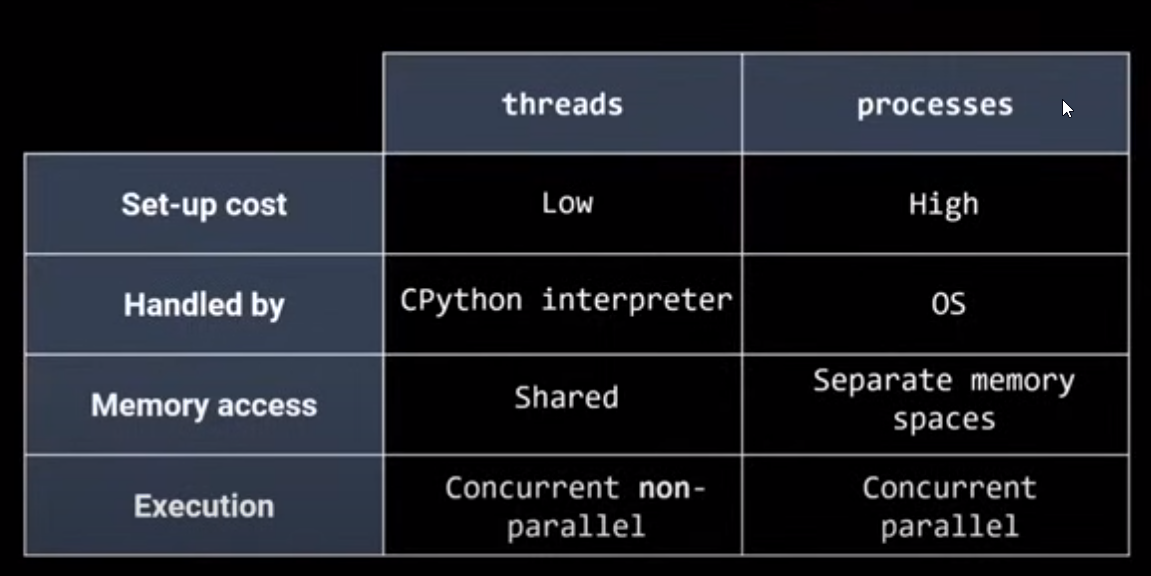

Main use of threads in Python is I/O bound tasks.  

## So why and how does Jax delay computations?

Computations are delayed if the overhead needed to start a new thread is smaller then the performance gain of doing so.

Jax uses C++ threading which allows parallel execution. Threads are used instead of processes to avoid excessive memory usage and bigger overhead that comes with processes.

Comprehensive writeup of how C++ threads are used in PyTorch: https://jedyang.com/post/multithreading-in-python-pytorch-using-c++-extension/

However, due to Jax issues with CPU ops delaying, it may not work as expected when performed on CPU. (https://github.com/google/jax/issues/20515)

## Multiprocessing overhead

In [36]:
import psutil

# List all current running Python processes
def count_python_processes():
    count = 0
    for process in psutil.process_iter(['pid', 'name', 'cmdline']):
        if 'python' in process.info['name'] or 'python' in ' '.join(process.info['cmdline']):
            count += 1
    return count

print(count_python_processes())

2


mul:   1.0, single process runtime:  3.8e-06s, multiprocessing single process runtime:   0.0022s, overhead   0.0022, current_n_processes: 2, inside_mp_n_processes: 3


mul: 1e+01, single process runtime:  6.2e-06s, multiprocessing single process runtime:   0.0029s, overhead   0.0029, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+02, single process runtime:  2.4e-05s, multiprocessing single process runtime:   0.0027s, overhead   0.0026, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+03, single process runtime:  0.00017s, multiprocessing single process runtime:    0.004s, overhead   0.0038, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+04, single process runtime:   0.0016s, multiprocessing single process runtime:   0.0085s, overhead   0.0069, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+05, single process runtime:    0.017s, multiprocessing single process runtime:    0.064s, overhead    0.047, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+06, single process runtime:      0.2s, multiprocessing single process runtime:     0.53s, overhead     0.33, current_n_processes: 2, inside_mp_n_processes: 3
mul:

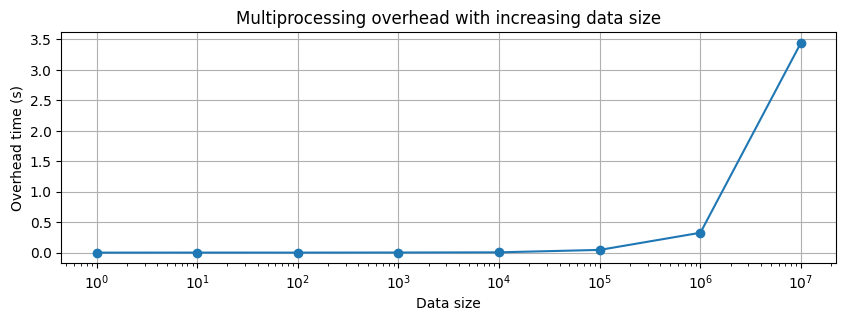

mul: 1e+01, single process runtime:  7.2e-06s, multiprocessing single process runtime:   0.0049s, overhead   0.0049, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+01, single process runtime:  6.9e-06s, multiprocessing single process runtime:   0.0048s, overhead   0.0047, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+01, single process runtime:    2e-05s, multiprocessing single process runtime:   0.0025s, overhead   0.0024, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+01, single process runtime:  8.6e-06s, multiprocessing single process runtime:   0.0036s, overhead   0.0036, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+01, single process runtime:  8.1e-06s, multiprocessing single process runtime:   0.0026s, overhead   0.0026, current_n_processes: 2, inside_mp_n_processes: 3
mul: 1e+01, single process runtime:  7.3e-06s, multiprocessing single process runtime:   0.0047s, overhead   0.0046, current_n_processes: 2, inside_mp_n_processes: 3
mul:

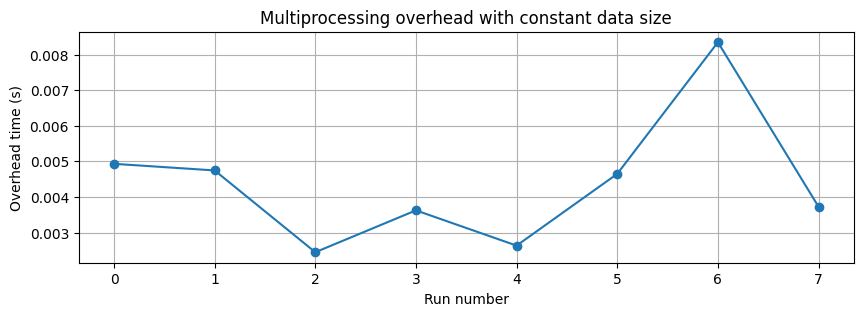

In [53]:
import multiprocessing as mp
import time
from time import sleep
from timeit import timeit
from typing import List
from random import randint

import matplotlib.pyplot as plt

exp_range = range(0, 8) 

l = [randint(0, 100) for _ in range(10)]

def sum_mp(l: List) -> int:
    return sum(l)

overhead_times = []
for i in exp_range:
    mul = 10**i
    single_process_runtime = timeit(lambda: sum_mp(l*mul), number=3)
    current_n_processes = count_python_processes()
    with mp.Pool(1) as p:
        inside_mp_n_processes = count_python_processes()
        multi_process_runtime = timeit(lambda: p.map(sum_mp, [l]*mul), number=3)
    overhead_time = multi_process_runtime - single_process_runtime
    overhead_times.append(overhead_time)
    print(f"mul: {float(mul):5.2}, single process runtime: {single_process_runtime:8.2}s, multiprocessing single process runtime: {multi_process_runtime:8.2}s, overhead {overhead_time:8.2}, current_n_processes: {current_n_processes}, inside_mp_n_processes: {inside_mp_n_processes}")

plt.figure(figsize=(10, 3))
plt.title("Multiprocessing overhead with increasing data size")
plt.plot([10**i for i in exp_range], overhead_times, marker='o')
plt.xticks([10**i for i in exp_range])
plt.xscale('log')
plt.ylabel("Overhead time (s)")
plt.xlabel("Data size")
plt.grid()
plt.show()

overhead_times = []
for _ in exp_range:
    mul = 10
    single_process_runtime = timeit(lambda: sum_mp(l*mul), number=3)
    current_n_processes = count_python_processes()
    with mp.Pool(1) as p:
        inside_mp_n_processes = count_python_processes()
        multi_process_runtime = timeit(lambda: p.map(sum_mp, [l]*mul), number=3)
    overhead_time = multi_process_runtime - single_process_runtime
    overhead_times.append(overhead_time)
    print(f"mul: {float(mul):5.2}, single process runtime: {single_process_runtime:8.2}s, multiprocessing single process runtime: {multi_process_runtime:8.2}s, overhead {overhead_time:8.2}, current_n_processes: {current_n_processes}, inside_mp_n_processes: {inside_mp_n_processes}")

plt.figure(figsize=(10, 3))
plt.title("Multiprocessing overhead with constant data size")
plt.plot([i for i in exp_range], overhead_times, marker='o')
plt.xticks([i for i in exp_range])
plt.ylabel("Overhead time (s)")
plt.xlabel("Run number")
plt.grid()
plt.show()

### Recurrence depth problem

Digging into the rabbithole of when python decided that the multiprocessing overhead code will result in exceeded recurrence depth.

In [1]:
import sys
print("recurrence depth:", sys.getrecursionlimit())

l = [i for i in range(100000000)]
print(f"l len: {len(l)}")
print(l[:10])

sum(l)

recurrence depth: 3000
l len: 100000000
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


4999999950000000

In [2]:
for i in range(0, 10):
    mul = 10**i
    print(f"mul: {mul}")
    l = [1] * mul
    print(f"l len: {len(l)}")


mul: 1
l len: 1
mul: 10
l len: 10
mul: 100
l len: 100
mul: 1000
l len: 1000
mul: 10000
l len: 10000
mul: 100000
l len: 100000
mul: 1000000
l len: 1000000
mul: 10000000
l len: 10000000
mul: 100000000
l len: 100000000
mul: 1000000000
l len: 1000000000


In [3]:
from time import sleep
from timeit import timeit

for i in range(0, 5):
    mul = 10**i
    print(f"mul: {mul}")
    runtime = timeit(lambda: sum([1]*mul), number=1)
    print(f"runtime: {runtime}")
    sleep(0.5)

mul: 1
runtime: 2.1699997887481004e-06
mul: 10
runtime: 3.0199998946045525e-06
mul: 100
runtime: 2.6100005925400183e-06
mul: 1000
runtime: 7.669000297028106e-06
mul: 10000
runtime: 9.787899944058154e-05


In [4]:
from time import sleep
from timeit import timeit

for i in range(0, 5):
    mul = 10**i
    print(f"mul: {mul}")
    runtime = timeit(lambda: sum([1]*mul), number=5)
    print(f"runtime: {runtime}")
    sleep(0.5)

mul: 1
runtime: 3.129999640805181e-06
mul: 10
runtime: 3.089999154326506e-06
mul: 100
runtime: 6.10899951425381e-06
mul: 1000
runtime: 2.8690000362985302e-05
mul: 10000
runtime: 0.0002483589996700175


In [6]:
import multiprocessing as mp
import time
from time import sleep
from timeit import timeit
from typing import List
from random import randint

import matplotlib.pyplot as plt

l = [randint(0, 100) for _ in range(10)]

def sum(l: List) -> int:
    return sum(l)

for i in range(0, 10):
    mul = 10**i
    print(f"mul: {mul}")
    # runtime = timeit(lambda: sum(l*mul), number=1)
    # print(l*mul)
    # sleep(0.5)


mul: 1
mul: 10
mul: 100
mul: 1000
mul: 10000
mul: 100000
mul: 1000000
mul: 10000000
mul: 100000000
mul: 1000000000


I really just made a self recursive function that never terminates and wasted 30 minutes diagnosing it.